# Import Libraries
Import LightGBM, scikit-learn, and other necessary libraries such as pandas and numpy.

In [189]:
# Import Libraries
import matplotlib.pyplot as plt
#from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm as lgb
from lightgbm import log_evaluation, early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import pickle, shap

In [190]:
import os
os.environ["PATH"] += os.pathsep + 'D:/Program Files (x86)/Graphviz2.38/bin/'

# Load Dataset
Load a dataset using pandas, such as a CSV file or a dataset from scikit-learn's built-in datasets.

In [191]:
# Load Dataset
df = pd.read_csv('../data/prepared_data.csv')

C:\Users\Steven\AppData\Local\Temp\ipykernel_940\2149143903.py:2: DtypeWarning: Columns (219) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/prepared_data.csv')


In [192]:
def downcast(df, verbose = True):
    start_memory = df.memory_usage().sum() / 1024 ** 2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == "object" or 'date' in dtype_name:
            pass
        elif dtype_name == "bool":
            df[col] = df[col].astype("int8")
        elif dtype_name.startswith("int") or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast = "integer")
        else:
            df[col] = pd.to_numeric(df[col], downcast = "float")
    end_memory = df.memory_usage().sum() / 1024 ** 2
    if verbose:
        print("{:.1f}% compressed".format(100 * (start_memory - end_memory) / start_memory))
    return df
df = downcast(df)

df.head(5)

49.4% compressed


,resp_id_KALRO,location_KALRO,treatment,treated,age_b,d_young_b,female_b,secondary_b,footwear_b,mumias_b,...,P_a_ureakg_18,P_a_picsqty_18,id,program,followed_lime_1all,followed_fert_1all,primary_all,hear_knows_lime_b,age_decades,age_squared
0,11004.0,1.0,Control,0,39.0,1.0,0.0,0.0,1.0,0.0,...,NaN,NaN,KALRO11004,KALRO,1,0.0,1.0,1.0,3.9,15.21
1,11005.0,1.0,Treated,1,24.0,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,KALRO11005,KALRO,0,1.0,1.0,0.0,2.4,5.76
2,11006.0,1.0,Treated,1,35.0,1.0,1.0,0.0,0.0,0.0,...,NaN,NaN,KALRO11006,KALRO,0,1.0,0.0,1.0,3.5,12.25
3,11007.0,1.0,Treated,1,54.0,0.0,1.0,0.0,1.0,0.0,...,NaN,NaN,KALRO11007,KALRO,1,1.0,0.0,0.0,5.4,29.16
4,11008.0,1.0,Control,0,27.0,1.0,1.0,0.0,1.0,0.0,...,NaN,NaN,KALRO11008,KALRO,0,1.0,1.0,1.0,2.7,7.29


In [193]:
[i for i in df.columns]

['resp_id_KALRO',
 'location_KALRO',
 'treatment',
 'treated',
 'age_b',
 'd_young_b',
 'female_b',
 'secondary_b',
 'footwear_b',
 'mumias_b',
 'size_shamba_b',
 'large_shamba_b',
 'literate_b',
 'acidity_problem_high_b',
 'acidity_problem_dk_b',
 'dk_sol_acid_b',
 'soil_test_b',
 'ever_used_lime_b',
 'used_fert_previous_season_b',
 'grow_legume_b',
 'heard_soil_tests_b',
 'ever_used_dap_b',
 'ever_used_can_b',
 'ever_used_npk_b',
 'used_fert_b',
 'heard_fert_b',
 'used_inputs_med_b',
 'used_inputs_high_b',
 'cog_med_b',
 'cog_high_b',
 'acres_high_b',
 'heard_lime_E',
 'knows_lime_E',
 'FO_id_KALRO',
 'cog_index_split',
 'lime_kg_2a',
 'purchased_plant',
 'purchased_top',
 'fert_kg_2a',
 'survey_completed',
 'survey_completed_f',
 'followed_lime_1s',
 'followed_fert_1s',
 'g10a_used_composting_E_d',
 'g10b_used_manure_E_d',
 'g10d_used_interc_E_d',
 'g10f_used_rhizobia_E_d',
 'g10g_used_imp_maize_E_d',
 'g10h_used_imp_legume_E_d',
 'g10i_used_c_disease_E_d',
 'g10j_used_c_striga_E_d'

# Preprocess Data
Handle missing values, encode categorical variables, and normalize or scale features if necessary.

In [194]:
y_lime = df['followed_lime_1all']
y_fert = df['followed_fert_1all']

X_pooled_basic = df[['treated','female_b','num_messages','program','age_decades']]

# encode program into a numeric variable
X_pooled_basic['program'] = X_pooled_basic['program'].astype('category').cat.codes

C:\Users\Steven\AppData\Local\Temp\ipykernel_940\3894725178.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pooled_basic['program'] = X_pooled_basic['program'].astype('category').cat.codes


# Split Data into Training and Testing Sets
Use train_test_split from scikit-learn to split the dataset into training and testing sets.

In [195]:
# Split Data into Training and Testing Sets
X = X_pooled_basic
y = y_lime
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1234)

In [196]:
# Preprocess Data
# Normalize features
scaler = MinMaxScaler()
X_train['age_decades'] = scaler.fit_transform(X_train['age_decades'].to_frame())
X_test['age_decades']  = scaler.transform(X_test['age_decades'].to_frame()) # this prevents data leakage

#X_train = pd.DataFrame(X_train, columns=X_pooled_basic.columns)
#X_test  = pd.DataFrame(X_test , columns=X_pooled_basic.columns)

cats = ['num_messages', 'program']

lgb_train = lgb.Dataset(X_train, categorical_feature=cats, label=y_train)
lgb_test  = lgb.Dataset(X_test , categorical_feature=cats, label=y_test, reference=lgb_train)

In [197]:
X_train

,treated,female_b,num_messages,program,age_decades
76488,1,NaN,4.0,3,NaN
118335,1,NaN,2.0,3,NaN
34910,1,NaN,2.0,2,NaN
17698,1,1.0,5.0,2,0.444445
128146,0,0.0,NaN,5,0.111111
...,...,...,...,...,...
60620,1,NaN,2.0,3,NaN
121909,1,0.0,NaN,4,0.382716
34086,1,1.0,3.0,2,0.555556
58067,1,NaN,4.0,3,NaN


In [198]:
pos_weight = (y_train==0).sum()/(y_train==1).sum()
print("pos_weight:", pos_weight)

pos_weight: 6.380073800738008


# Train LightGBM Model
Use LightGBM's LGBMClassifier or LGBMRegressor to train the model on the training data.

In [215]:
# Train LightGBM Model
# Example: Classification task
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'is_unbalance': True,  # Adjust for class imbalance
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.001,
    'min_data_in_leaf': 50,
    'feature_fraction': 1.0,
    'verbosity': 1,
    'num_iterations': 10000,
    'seed': 1234
}

training_scores={}

model = lgb.train(
    params, 
    lgb_train, 
    valid_sets=[lgb_test],
    callbacks=[
        lgb.early_stopping(stopping_rounds=5),
        lgb.record_evaluation(training_scores),
        ]
    )

y_pred = model.predict(X_test)
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
y_pred = model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_pred))

[LightGBM] [Info] Number of positive: 15718, number of negative: 100282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000897 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 116000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135500 -> initscore=-1.853180
[LightGBM] [Info] Start training from score -1.853180
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[301]	valid_0's binary_logloss: 0.373816


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [214]:
model = lgb.LGBMClassifier(is_unbalance=True)
model.fit(
    X_train, 
    y_train)
y_pred = model.predict(X_test)
print("Testing Accuracy:", accuracy_score(y_test, y_pred))
y_pred = model.predict(X_train)
print("Training Accuracy:", accuracy_score(y_train, y_pred))

[LightGBM] [Info] Number of positive: 15718, number of negative: 100282
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000591 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 101
[LightGBM] [Info] Number of data points in the train set: 116000, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.135500 -> initscore=-1.853180
[LightGBM] [Info] Start training from score -1.853180
Testing Accuracy: 0.7495538831561797
Training Accuracy: 0.7509741379310345


array([0, 0, 0, ..., 0, 0, 0], shape=(12889,), dtype=int8)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

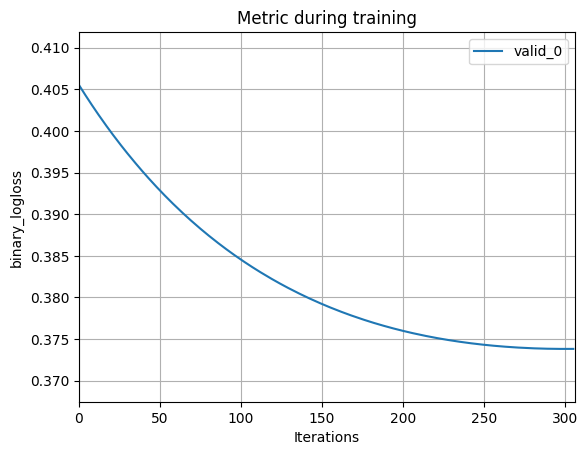

In [202]:
lgb.plot_metric(training_scores)

In [203]:
model.feature_importance()

array([1229, 1256,  602,  725, 5218], dtype=int32)

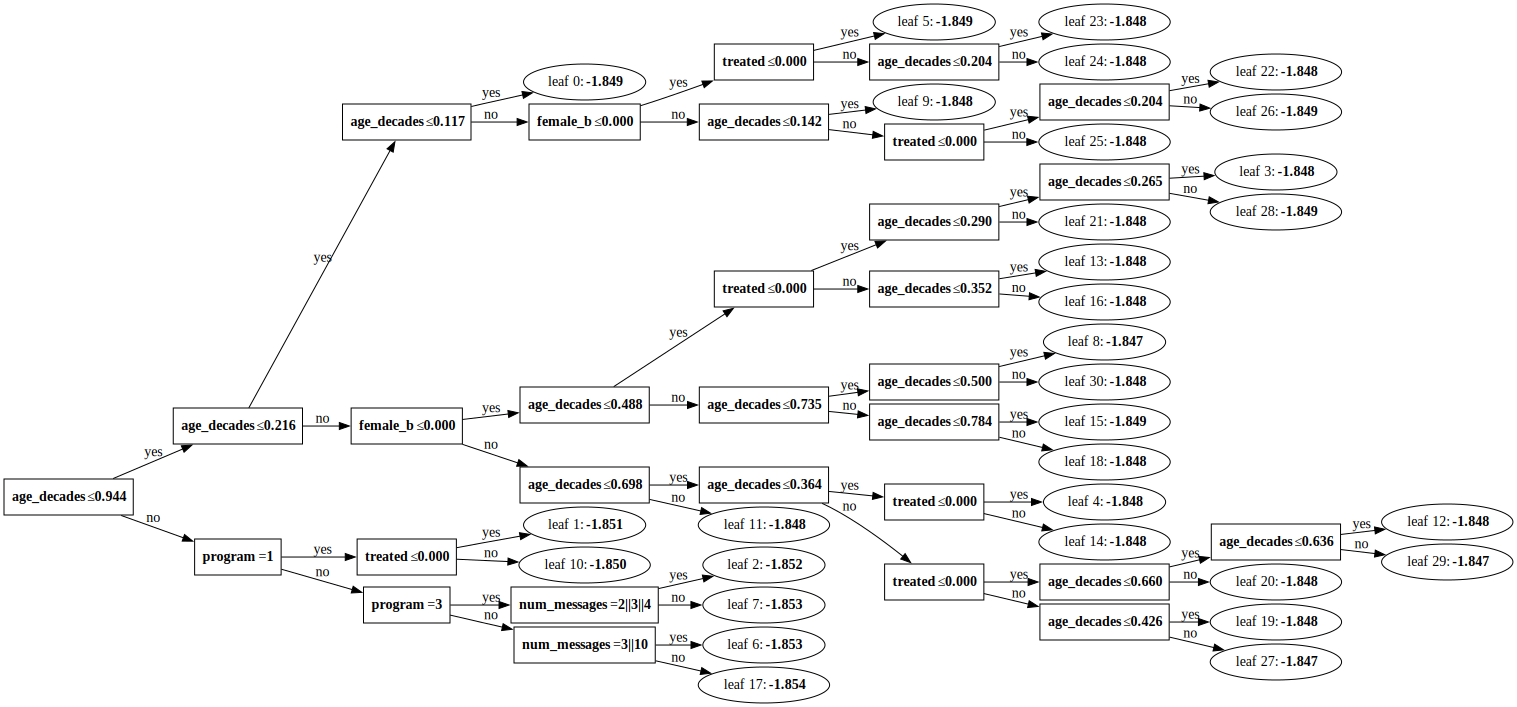

In [204]:
lgb.create_tree_digraph(model)

# Evaluate Model Performance
Evaluate the model using metrics such as accuracy, precision, recall, or mean squared error, depending on the task.

(array([7.500e+01, 1.900e+01, 8.334e+03, 7.000e+00, 0.000e+00, 1.580e+02,
        3.690e+02, 2.440e+02, 9.590e+02, 2.724e+03]),
 array([0.10882869, 0.12931529, 0.14980189, 0.17028849, 0.19077508,
        0.21126168, 0.23174828, 0.25223488, 0.27272147, 0.29320807,
        0.31369467]),
 <BarContainer object of 10 artists>)

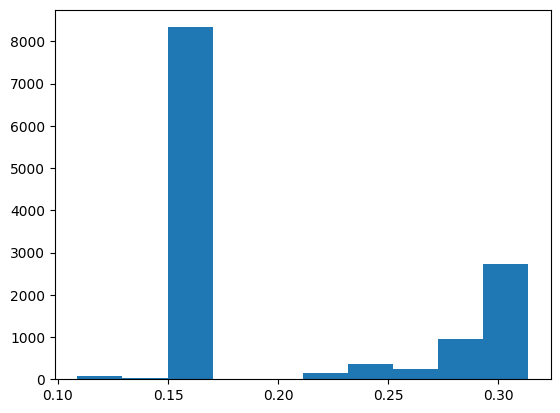

In [205]:
# Evaluate Model Performance
# Example: Classification task
y_pred = model.predict(X_test)
plt.hist(y_pred)
#accuracy = accuracy_score(y_test, y_pred)
#print(f"Accuracy: {accuracy:.2f}")

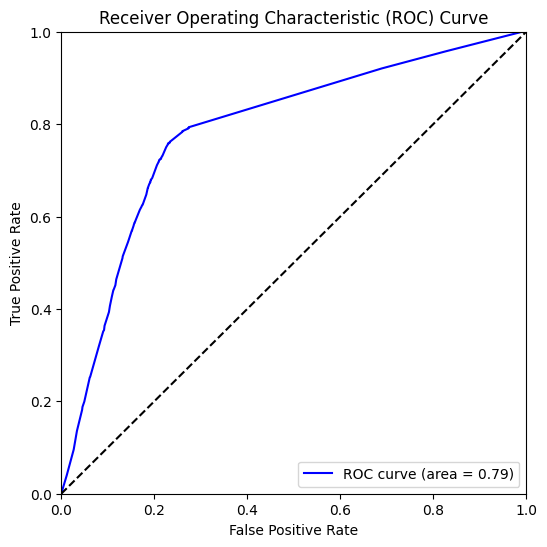

In [206]:
# Plot the ROC curve
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [179]:
X_test.shape[0]

25778

In [178]:
# sample 1000 rows from x_eval
np.random.seed(42)
x_sample = X_test[np.random.choice(X_test.shape[0], size=1000, replace=False), :]
# shap values
explainer = shap.TreeExplainer(model, x_sample, feature_names=X_pooled_basic.columns, model_output='probability')
#explainer = shap.TreeExplainer(model, feature_names=X_pooled_basic.columns)
shap_values = explainer(x_sample, check_additivity=True)
pickle.dump(shap_values, open('../output/lightgbm_shap_values.pkl', 'wb'))

InvalidIndexError: (array([ 9722, 21178, 23256,  4265,  1045,  4884,  5910, 13375, 18264,
       16631, 14173,  8654, 16387, 14874, 14411,  7258, 16801, 22862,
        4438, 18907,  8105, 16675, 21671, 20398, 23226,  5019,  4871,
       25066, 21780, 11762,  4471, 18283, 15610,  7486, 12425,  9409,
        4720,  7839, 11800,  5365, 24149, 16200,   230, 22819, 13816,
       16073,  8451, 14636,  1103, 20370,  8960,  4347, 25361,  4563,
       16884,  9683,  3745, 25567, 15875, 11743, 24545, 24669,  9598,
       11377, 20084,  6136, 10249, 23713,   880, 10041,  1512, 20475,
       10513,  3776, 11066, 24891, 25074,   341,  6134,  4520, 25663,
        1202, 15763, 13825, 20546,  6692,  4699, 10205, 15851, 20842,
        9544,  9725, 13748, 21641,  5720, 20061,  5359, 11021, 18161,
       20770, 10543,  2595, 15437, 19656,  6887, 13209, 11170, 12507,
       19957,  4813, 12631, 14001, 15143, 12315, 19962, 16270,   196,
       20261,  2730,  7094,  8295, 20403, 12335, 14836,  3964,  9152,
        7113, 16637,  3316,  3507, 22125,   397,  3486, 13678, 15832,
        4785, 24307,  3919, 19249,  1923,  2635, 21014, 11808,  2008,
       12361, 17752, 11583, 23547, 17080,   866,  7922, 21209, 21347,
       18367, 23615,  3386, 23965, 15068,  7241, 24671,  1227,  7467,
       20328,  2463, 17011, 12729, 19922, 10842,  3995, 22517,  6206,
       20363,  2762,  2136, 21430, 22249, 12343, 14913, 15242,  5199,
       16159, 21189, 24660, 23992,  7466,  5001, 14148, 10869,  1959,
        1644,  9826, 18143, 23919, 15465, 17315, 20603,  9136, 16262,
       22880, 16809,  9188, 19014, 22894, 25735, 19211, 11301,  7911,
       13337,  2201, 10199, 20409,  5102,  1668,   640, 17277, 25093,
       21593, 11403,  8516, 12137,  5638, 20569, 12077,  2676,  2225,
       23656, 16124, 19530,  8607,  5883,  3971, 16069, 17654, 21192,
       22147,  2325,  8158,  1808, 21602,  4211,  9922, 23241, 20849,
       10254, 19549,  4744, 25147, 19535, 16670, 25697, 16108,  4479,
       10158, 17757, 10612,  3737, 11192, 24608, 23846, 14105, 20777,
       23673,  2157, 12400, 12657, 14321, 22580,  3455,   382, 16329,
       14240,  7363, 15458, 20993, 10063,  2275, 23010, 16186, 16292,
        8270, 11527, 17545, 20972,  2505, 16113, 16203, 12480,  7191,
        4202, 12758, 12188,  7547,  1448, 15877, 16745,   199, 14214,
        3707, 24270, 25439, 14517,  4345,  9233, 17074,  5081, 15487,
       24271, 14697, 10398,  3639, 12670, 21955,  2973, 16219, 22092,
       18357, 12011,  7104,  6562,  3979, 12210, 11899,  6377,  3843,
       13371, 10852,  7306, 13736,  8887, 19524,  9360,  4706, 24129,
       15824, 14273, 14920,  3993, 12044,  6842,  8178,  1684,  5561,
       13632, 16851, 18531, 22970, 24197, 21442, 14808, 23202, 25607,
       20340,  9526, 18769,  9976,  2508,  3735,  2359, 21048, 19168,
       20650, 23397, 20784, 10572,  7613, 19517, 21401,  7198, 13198,
       13060, 23017, 10855,  7721,  8743,  9349,  4160, 24054, 17502,
       24619, 13973,  8588,  6600, 25613, 11201, 24638,  6865, 17237,
       21958,  3100, 16135, 16978,  4448,  3296, 10376, 22685, 16357,
        2830,  2516,  2790, 18879, 18784, 11917, 11057, 25768, 11521,
         283, 24788,  8797, 19652, 14885, 11263, 22930, 17919,  8072,
       20248,  9008,  5551,  4189, 11686, 12892,  7808,  6020,  6442,
       22821,  7870,  1427, 23119, 17993,   674, 14304,  5045,  7784,
       24066, 25602, 24378, 21996, 16601, 12530, 25449, 14752, 10989,
       13856,  3410, 11769, 22639,  4540,  5284, 10650,   312,  2797,
       12016,  6769, 11506, 12069,  9992, 14705, 20860, 16379, 16833,
         428, 11924,  3922, 11961,   752,  5553, 25269,  7901, 21835,
       11149, 23013, 22863, 17931, 15665, 19847,  5685, 25438, 15294,
        1108,  7356, 16871,  8874,  4286, 13797, 19024,  8764,  2734,
       24164, 20348,  9668, 17736, 23151, 14813, 16620, 16004,  8019,
       13980,  4110,  3268,  6388, 25192,  7646,  5436,  9014, 17474,
       18842, 22372,   733, 23168,  3058, 12554, 12054,  6595,   423,
        3070,  1422, 17798, 11571, 16750, 22407,  9798,  7809,  6921,
       22774,   993, 17328,  7139, 15017,  7712, 13820, 24004,  7449,
        2805,   501, 24814, 24279,  3402,  5762, 17663, 10909,  5211,
       23004,  2227,  7955, 13162, 25369, 20280, 19764, 13474, 15131,
       14155,  8318, 11432,  9338,   323, 15991, 21716, 19597,  8443,
       20555, 22429,  6404, 18063, 17710, 13695,  2752, 16605,  6433,
       15081, 24308,  5331, 11152, 17408,  1915, 11051, 10404, 25348,
       11142, 22852, 17201,  8687,   150,  1598, 23687,  9758, 13995,
       20380,  8799, 12570, 14163, 13172, 15245, 10019, 11895, 17389,
       16565, 25201,  2229, 20290, 14213,  2937,  7174,  1122,  9739,
       10959, 25451, 11178, 13531,  8477,  2813, 16229, 21270,  8064,
       14015,  1901, 17950, 20226, 21412, 10235, 13587, 14263,  3226,
        7946, 19243,  1346, 16643,  1947,  8629, 23905,  3592, 21104,
        9994, 14649, 14421, 24517, 22285,  3318,  2266,   512, 17366,
       23763, 25503, 22006,  3383, 22892,  3111, 22686, 21669,  6490,
        1710, 11701,  9651,  4685, 10138, 19475, 18379,  9987,  2898,
       19425, 18267,  9125, 21440, 10676, 25164,  9614, 11947, 13580,
       11764,  4293, 20097,  2420,  8188,  8151, 15105,  9831, 17059,
        8557,  5194, 13487, 20051, 18946,  3352,   852,  3366, 12282,
       13610, 21937,  9426, 24401, 10957, 12022,  6137,  6672, 18053,
       12166,  1738, 22855, 25600, 21811,  2153, 12272, 12493, 20514,
        5214, 14144,   896, 25326,  2140, 23346, 15415,  7112,  3181,
        8466, 14525, 15926, 11038,  3399, 15272, 10935,  3197, 21868,
       23474, 24236, 18089, 10575, 18496, 15162,  7285,  7794, 23553,
       15969, 23109, 12633,  5245, 19753, 14613, 20574,   274,   167,
       22069,  5683, 21052, 25463,  6011, 23039,  2084, 16664, 18129,
       10658,  6188,  5456, 21053, 20247, 19295,  2141, 24456,  8883,
       24357, 16778,  2760, 20211, 10902,   247, 11131, 17116,  1190,
       23923,  8358, 21957, 13888, 19955, 13526,  5954,  3949, 19854,
       19175,  3792,  6906,  9845,  4003,  5348, 18220,  1743,  6576,
       10423, 25488, 19543, 11309,  1940,  1246, 10243, 24747, 21463,
         243,  8426,  3694, 22717, 21159, 19709, 19852, 23607,  9459,
       23768, 13725, 17577, 24903, 13974,  3901, 25178, 15426, 23853,
        1489,  1603, 14471, 25183, 20863, 12268,  3394, 15079, 20759,
        2408, 20802, 15785,  5098, 21409, 15098,  8459, 14455, 11193,
       25491, 17383, 13585,  4981, 20868, 25193, 11658,  3698, 25227,
       21684, 17525, 22798, 19202,   843,  6453,  6880, 21370, 20755,
        9189,  2641,  8247, 17623, 21916, 20390, 10277,  7178, 23995,
        9495, 10507,  5048, 20037, 15571, 12759,  1889, 15121, 17183,
        1087,  9002,  5570, 10821, 12622, 21380, 10877,  8316, 11408,
       13625,  8310, 16599, 18632, 10285, 21207,  6552, 22842,    52,
       25447, 10279, 10219,  9888, 11388,  7100, 24774,  4794, 18830,
       19653,  2748, 10463,  5673,  7024,  2476, 24386, 20982, 14253,
        2533, 24607, 18009,  3799, 23146, 20946,  3541, 15224,   280,
       17333,  3643,  5500,  2564, 14366,  2240, 24964,   738, 21860,
       17437, 21720,  7267, 19746,  6504, 13702,  6224, 18904, 16603,
       17167,  8304,  7152, 22934, 12032,   536, 10122,  5780,  9749,
        1441,  2270,  6223, 19853, 19890,    34,  6232, 14223, 19261,
       12980, 19787,  3498, 21756,  9960, 13770,  8233,   626,  5658,
       13367, 13712,  2740,  7482,   601,  9939, 24144,  5589,  4546,
       16399, 17423,   959,  3050,  8344,  8922,  2386,  9355,  6726,
       19272, 14644, 14776,  7049,  1475, 13402, 21690, 20795, 10202,
       12770, 16407, 11060,  4306, 12683, 25553, 21134, 15789,  3014,
       15633, 15963, 18306, 17671,  3492, 14666, 14872,  9920, 12637,
        8550], dtype=int32), slice(None, None, None))

In [11]:
#shap_interactions = explainer.shap_interaction_values(x_sample)
#shap_interactions[1]

In [12]:
#np.mean(shap_interactions[0], axis=0)

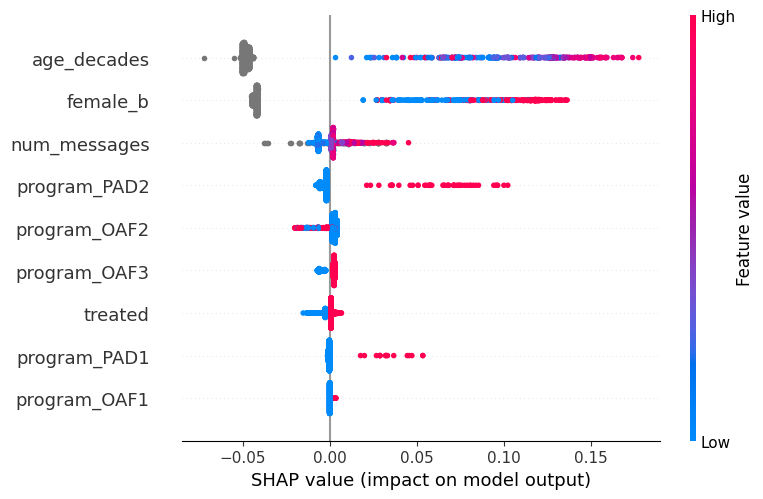

In [13]:
fig = plt.figure(figsize=(10, 15))
fig.add_axes(shap.plots.beeswarm(shap_values, max_display=20, show=False))
fig.tight_layout()
fig.savefig('../output/shap_beeswarm_all.pdf')

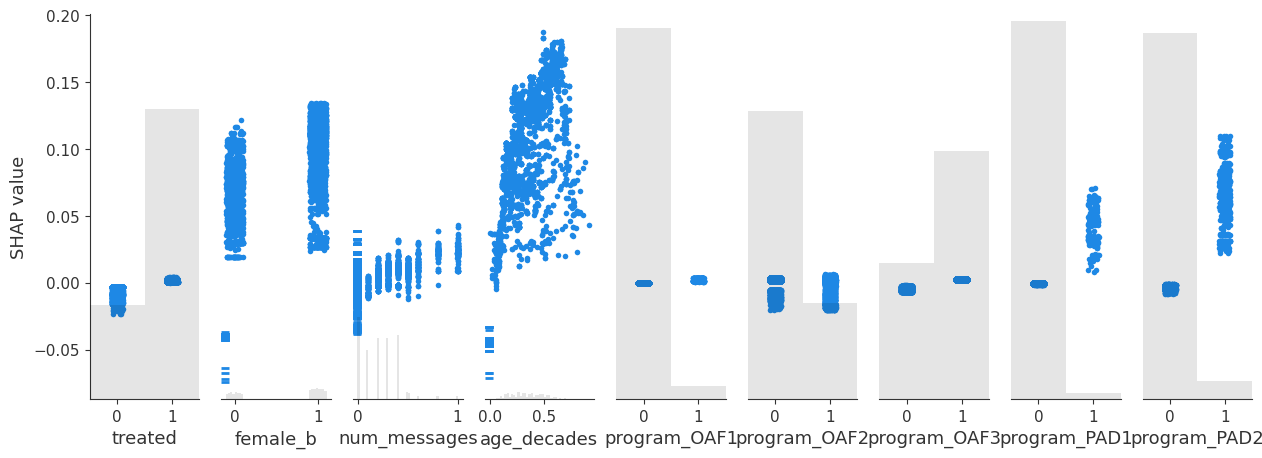

In [20]:
shap.plots.scatter(shap_values[:, :])

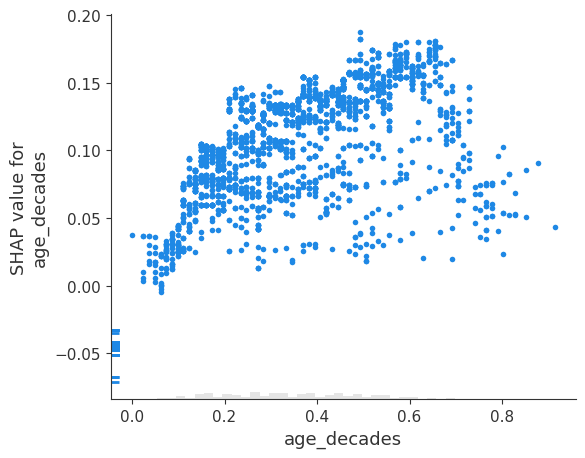

In [21]:
shap.plots.scatter(shap_values[:, "age_decades"])

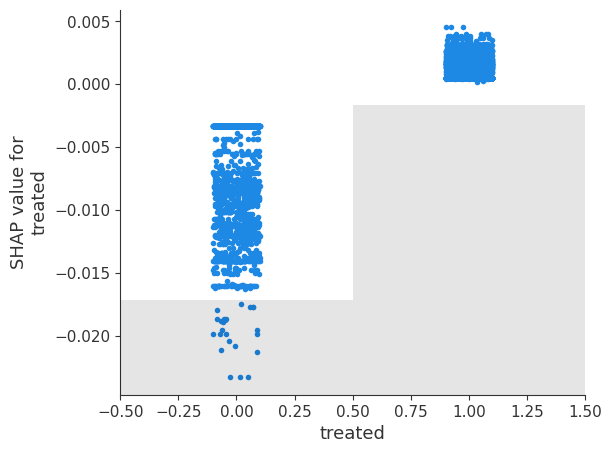

In [23]:
shap.plots.scatter(shap_values[:, "treated"])

In [ ]:
#shap.plots.heatmap(shap_values, instance_order=shap_values.sum(1))
shap.plots.heatmap(shap_values)